# Please stay in formation

## Abstract
The modern game of football has developed into an incredibly tactical game as opposed to what was being played 15 years ago. The first point of change was ever expanding types of formations that could be played, making it confusing for managers these days to cope with what is the best suited formation to counter. 

Here we are going to build a regressive neural network that can predict the most effective formation for a team to use to counter the oppositions formation. To make this model effective it will consider:

> - Opponents formation
> - Both teams current form with a certain formation
> - Home vs Away teams
> - Match outcomes

This tutorial demonstrates the complete pipeline for prediciting The best formation types using PyTorch. Using match data from SportMonks API, we engineer features including team form, head-to-head records and win rate to predict whether a team should lineup with a 3-back, 4-back or 5-back defensive system. We are goign to compare three PyTorch neural network architectures:

> - Simple feedforward network
> - Medium network
> - Deep Learning Network with batch normalisation

The tutorial will cover data preprocessing, feature engineering, model training with regularisation techniques anf critical evaluation of results.

## Learning Objectives
By following this tutorial, you will learn to:
> - Preprocess and engineer features from real-world sports data
> - Build and train neural network classifiers in PyTorch
> - Implement regularisation techniques including dropout, early stopping, and weight decay
> - Compare multiple model architectures and analyse their performance
> - Critically evaluate model results against a baseline

## Table of Contents

1. [Related Work](#related-work)
2. [Data](#data)
    - [Data Acquisition](#data-acquisition)
    - [Data Preprocessing](#data_preprocessing)
    - [Train/Test Split](#traintest-split)
3. [References](#references)

---

## Related Work -> How mine differs
To begin predicting optimal football formations, it is key to understand team tactics and how they can influence match outcomes. The study by Lee & Jung (2023) explores this problem using deep neural networks to predict team tactics, making it an applicable study to assist in predicting an optimal formation.

Rather than focusing solely on match outcomes, the paper proposes a multi-output deep neural network that attempts to infer underlying tactical strategies from a range of features. Player positions and movements are represented as structured inputs to the model, allowing tactical patterns to be learned directly from data.

This approach closely aligns with the methodology adopted in this tutorial, using features such as team formation, recent form, match venue and historical match outcomes. By doing so, the model aims to learn how formations perform under different contextual conditions and predict the most effective formation to counter an opponent.

Unlike the PyTorch MNIST tutorial [ref], this tutorial uses real-world tabular sports data rather than image classification, which presents different challenges such as class imbalance and limited feature signal. Compared to [another tutorial], we include multiple architecture comparisons rather than a single model.


## Required Packages

In [ ]:
# Install required packages (run this ONCE)
# Uncomment and run if you haven't installed these yet:

# conda install -y pandas numpy matplotlib scikit-learn
# conda install -y pytorch torchvision torchaudio -c pytorch
# conda install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data
Data was collected using the SportMonks API (free trial). To maintain reproducability and stability and due to API rate limitations, a static CSV version is used for this notebook.

### Data Loading
Below is the code to load the dataset from the same folder as this notebook. I have also attached the link to download the folder from my github.

In [6]:
# Load the raw dataset
df_raw = pd.read_csv('danish_superliga_fixtures.csv')
df_raw.head()

,fixture_id,date,home_team_id,home_team_name,away_team_id,away_team_name,home_goals,away_goals,home_formation,away_formation,goal_diff,result
0,16808043,2010-07-17 15:00:00,1789,Odense BK,1371,Esbjerg,3,0,4-4-2,4-4-1-1,3,H
1,16808046,2010-07-18 12:00:00,211,Horsens,939,FC Midtjylland,0,2,4-4-1-1,4-4-1-1,-2,A
2,16808053,2010-07-18 14:00:00,2394,Nordsjælland,86,Silkeborg IF,4,1,4-3-3,4-4-1-1,3,H
3,16808049,2010-07-18 14:00:00,2356,Randers FC,293,Brøndby IF,3,2,4-4-1-1,4-4-2,1,H
4,16808056,2010-07-18 16:00:00,390,Sønderjyske Fodbold,85,FC København,1,3,4-5-1,4-4-2,-2,A


### Data Preprocessing
Once the data has been collected it will need to be cleaned and normalized before being passed into the neural network. Rows with null data values, duplicates and columns with unnecessary data will be need to be removed to have the highest quality data available to us. Having high quality data is the backbone of an accurate model.


In [7]:
# Convert date to datetime for proper sorting
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Select all essential columns - we need full match context
essential_cols = ['date', 'home_team_id', 'away_team_id', 'home_formation', 'away_formation', 'result']
df_clean = df_raw[essential_cols].copy()

# Sort by date to ensure chronological order
df_clean = df_clean.sort_values('date').reset_index(drop=True)

# FILTER: Only keep matches with a WINNER (exclude draws)
print(f"Original dataset: {len(df_clean)} matches")
df_clean = df_clean[df_clean['result'] != 'D'].reset_index(drop=True)
print(f"✓ After removing draws: {len(df_clean)} matches")
print(f"  Home wins: {(df_clean['result'] == 'H').sum()}")
print(f"  Away wins: {(df_clean['result'] == 'A').sum()}")

print(f"\n✓ Cleaned dataset shape: {df_clean.shape}")
print(f"✓ Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
print(f"✓ Unique home formations: {df_clean['home_formation'].nunique()}")
print(f"✓ Unique away formations: {df_clean['away_formation'].nunique()}")

df_clean.head()


Original dataset: 2866 matches
✓ After removing draws: 2117 matches
  Home wins: 1226
  Away wins: 891

✓ Cleaned dataset shape: (2117, 6)
✓ Date range: 2010-07-17 to 2024-05-31
✓ Unique home formations: 21
✓ Unique away formations: 20


,date,home_team_id,away_team_id,home_formation,away_formation,result
0,2010-07-17 15:00:00,1789,1371,4-4-2,4-4-1-1,H
1,2010-07-18 12:00:00,211,939,4-4-1-1,4-4-1-1,A
2,2010-07-18 14:00:00,2394,86,4-3-3,4-4-1-1,H
3,2010-07-18 14:00:00,2356,293,4-4-1-1,4-4-2,H
4,2010-07-18 16:00:00,390,85,4-5-1,4-4-2,A


### Creating Training Records

For each match, we create TWO training records:
1. **Winner's perspective**: Formation that led to victory
2. **Loser's perspective**: Formation that led to defeat

This teaches the model from both winning AND losing formations, making it more robust. This is important when there isn't much data available for the model.

In [8]:
# Create winning formation records (both perspectives)
records = []

for idx, row in df_clean.iterrows():
    match_date = row['date']
    home_team_id = row['home_team_id']
    away_team_id = row['away_team_id']
    home_formation = row['home_formation']
    away_formation = row['away_formation']
    result = row['result']
    
    if result == 'H':  # Home team won
        # WINNING RECORD: Home team won with their formation
        records.append({
            'date': match_date,
            'team_id': home_team_id,
            'opponent_id': away_team_id,
            'is_home': 1,
            'team_formation': home_formation,
            'opponent_formation': away_formation,
            'won': 1
        })
        
        # LOSING RECORD: Away team lost with their formation
        records.append({
            'date': match_date,
            'team_id': away_team_id,
            'opponent_id': home_team_id,
            'is_home': 0,
            'team_formation': away_formation,
            'opponent_formation': home_formation,
            'won': 0
        })
    
    else:  # Away team won (result == 'A')
        # WINNING RECORD: Away team won with their formation
        records.append({
            'date': match_date,
            'team_id': away_team_id,
            'opponent_id': home_team_id,
            'is_home': 0,
            'team_formation': away_formation,
            'opponent_formation': home_formation,
            'won': 1
        })
        
        # LOSING RECORD: Home team lost with their formation
        records.append({
            'date': match_date,
            'team_id': home_team_id,
            'opponent_id': away_team_id,
            'is_home': 1,
            'team_formation': home_formation,
            'opponent_formation': away_formation,
            'won': 0
        })

df_clean = pd.DataFrame(records).reset_index(drop=True)

print(f"Dataset expanded to include both winning and losing perspectives:")
print(f"  Total records: {len(df_clean)}")
print(f"  Winning records: {df_clean['won'].sum()}")
print(f"  Losing records: {(1 - df_clean['won']).sum()}")
print(f"\nFirst 10 rows:")
df_clean.head(10)

Dataset expanded to include both winning and losing perspectives:
  Total records: 4234
  Winning records: 2117
  Losing records: 2117

First 10 rows:


,date,team_id,opponent_id,is_home,team_formation,opponent_formation,won
0,2010-07-17 15:00:00,1789,1371,1,4-4-2,4-4-1-1,1
1,2010-07-17 15:00:00,1371,1789,0,4-4-1-1,4-4-2,0
2,2010-07-18 12:00:00,939,211,0,4-4-1-1,4-4-1-1,1
3,2010-07-18 12:00:00,211,939,1,4-4-1-1,4-4-1-1,0
4,2010-07-18 14:00:00,2394,86,1,4-3-3,4-4-1-1,1
5,2010-07-18 14:00:00,86,2394,0,4-4-1-1,4-3-3,0
6,2010-07-18 14:00:00,2356,293,1,4-4-1-1,4-4-2,1
7,2010-07-18 14:00:00,293,2356,0,4-4-2,4-4-1-1,0
8,2010-07-18 16:00:00,85,390,0,4-4-2,4-5-1,1
9,2010-07-18 16:00:00,390,85,1,4-5-1,4-4-2,0


### Feature Engineering - Team Recent Form

Calculate each team's most successful formation from their recent winning matches. 
This captures which formations have worked well for teams recently.

In [9]:
def get_team_recent_winning_form(df, team_id, fixture_idx, num_recent=5):
    """Original function - keep as is"""
    previous_records = df[df.index < fixture_idx].copy()
    winning_records = previous_records[
        (previous_records['team_id'] == team_id) & 
        (previous_records['won'] == 1)
    ].tail(num_recent)
    
    if len(winning_records) == 0:
        return None
    
    formations = winning_records['team_formation'].tolist()
    most_common_formation = Counter(formations).most_common(1)[0][0]
    
    return most_common_formation


def get_team_recent_win_rate(df, team_id, fixture_idx, num_recent=10):
    """NEW: Get team's win rate in recent matches"""
    previous_records = df[df.index < fixture_idx].copy()
    recent_matches = previous_records[
        previous_records['team_id'] == team_id
    ].tail(num_recent)
    
    if len(recent_matches) == 0:
        return 0.5  # Neutral if no history
    
    win_rate = recent_matches['won'].mean()
    return win_rate


def get_team_consistency(df, team_id, fixture_idx, num_recent=5):
    """NEW: How consistent is team with formations?"""
    previous_records = df[df.index < fixture_idx].copy()
    recent_matches = previous_records[
        previous_records['team_id'] == team_id
    ].tail(num_recent)
    
    if len(recent_matches) == 0:
        return 0.2  # Maximum variety if no history
    
    formations = recent_matches['team_formation'].tolist()
    unique_formations = len(set(formations))
    consistency = 1 - (unique_formations / len(formations))  # 1 = always same, 0 = always different
    return consistency

def get_head_to_head_record(df, team_id, opponent_id, fixture_idx, num_recent=10):
    """How does this team historically perform vs this opponent?"""
    previous = df[df.index < fixture_idx]
    h2h = previous[
        ((previous['team_id'] == team_id) & (previous['opponent_id'] == opponent_id))
    ].tail(num_recent)
    
    if len(h2h) == 0:
        return 0.5  # Neutral if first matchup
    
    return h2h['won'].mean()  # Win rate (0-1)


df_features = df_clean.copy()

team_recent_forms = []
opponent_recent_forms = []
team_win_rates = []
opponent_win_rates = []
team_consistency = []
opponent_consistency = []
team_h2h = []
opponent_h2h = []

print("Calculating enhanced features...")

for idx in range(len(df_features)):
    if idx % 1000 == 0:
        print(f"  Processing record {idx}/{len(df_features)}...")
    
    team_id = df_features.loc[idx, 'team_id']
    opponent_id = df_features.loc[idx, 'opponent_id']
    
    # Original features
    team_form = get_team_recent_winning_form(df_features, team_id, idx, num_recent=5)
    team_recent_forms.append(team_form)
    
    opponent_form = get_team_recent_winning_form(df_features, opponent_id, idx, num_recent=5)
    opponent_recent_forms.append(opponent_form)
    
    # NEW: Win rates
    team_wr = get_team_recent_win_rate(df_features, team_id, idx, num_recent=10)
    team_win_rates.append(team_wr)
    
    opponent_wr = get_team_recent_win_rate(df_features, opponent_id, idx, num_recent=10)
    opponent_win_rates.append(opponent_wr)
    
    # NEW: Consistency
    team_cons = get_team_consistency(df_features, team_id, idx, num_recent=5)
    team_consistency.append(team_cons)
    
    opponent_cons = get_team_consistency(df_features, opponent_id, idx, num_recent=5)
    opponent_consistency.append(opponent_cons)

    # NEW: H2H records
    team_h2h_record = get_head_to_head_record(df_features, team_id, opponent_id, idx)
    team_h2h.append(team_h2h_record)
    
    opponent_h2h_record = get_head_to_head_record(df_features, opponent_id, team_id, idx)
    opponent_h2h.append(opponent_h2h_record)

df_features['team_h2h_vs_opponent'] = team_h2h
df_features['opponent_h2h_vs_team'] = opponent_h2h

df_features['team_recent_winning_form'] = team_recent_forms
df_features['opponent_recent_winning_form'] = opponent_recent_forms
df_features['team_win_rate'] = team_win_rates
df_features['opponent_win_rate'] = opponent_win_rates
df_features['team_consistency'] = team_consistency
df_features['opponent_consistency'] = opponent_consistency

# Fillna
df_features['team_recent_winning_form'] = df_features['team_recent_winning_form'].fillna(df_features['team_formation'])
df_features['opponent_recent_winning_form'] = df_features['opponent_recent_winning_form'].fillna(df_features['opponent_formation'])

print("✓ Enhanced features calculated successfully")
df_features.head()

Calculating enhanced features...
  Processing record 0/4234...
  Processing record 1000/4234...
  Processing record 2000/4234...
  Processing record 3000/4234...
  Processing record 4000/4234...
✓ Enhanced features calculated successfully


,date,team_id,opponent_id,is_home,team_formation,opponent_formation,won,team_h2h_vs_opponent,opponent_h2h_vs_team,team_recent_winning_form,opponent_recent_winning_form,team_win_rate,opponent_win_rate,team_consistency,opponent_consistency
0,2010-07-17 15:00:00,1789,1371,1,4-4-2,4-4-1-1,1,0.5,0.5,4-4-2,4-4-1-1,0.5,0.5,0.2,0.2
1,2010-07-17 15:00:00,1371,1789,0,4-4-1-1,4-4-2,0,0.5,1.0,4-4-1-1,4-4-2,0.5,1.0,0.2,0.0
2,2010-07-18 12:00:00,939,211,0,4-4-1-1,4-4-1-1,1,0.5,0.5,4-4-1-1,4-4-1-1,0.5,0.5,0.2,0.2
3,2010-07-18 12:00:00,211,939,1,4-4-1-1,4-4-1-1,0,0.5,1.0,4-4-1-1,4-4-1-1,0.5,1.0,0.2,0.0
4,2010-07-18 14:00:00,2394,86,1,4-3-3,4-4-1-1,1,0.5,0.5,4-3-3,4-4-1-1,0.5,0.5,0.2,0.2


### Data Visualisation

Visualize the dataset to understand formation distributions and win rates.

In [10]:
# Summary statistics
model_data = df_features[['opponent_formation', 'is_home', 'team_recent_winning_form', 
                           'opponent_recent_winning_form', 'team_formation', 'won']].copy()

print("=" * 70)
print("DATASET SUMMARY")
print("=" * 70)
print(f"Shape: {model_data.shape}")
print(f"Columns: {list(model_data.columns)}")

print(f"\nFormation Frequency (Team Formations):")
formations = sorted(model_data['team_formation'].unique())
for i, formation in enumerate(formations, 1):
    count = (model_data['team_formation'] == formation).sum()
    print(f"  {i:2d}. {formation:10s} - {count:5d} ({count/len(model_data)*100:5.1f}%)")

print(f"\nTotal unique formations: {model_data['team_formation'].nunique()}")

print(f"\nOutcome Distribution:")
print(f"  Wins: {model_data['won'].sum():5d} ({model_data['won'].sum()/len(model_data)*100:5.1f}%)")
print(f"  Losses: {(1-model_data['won']).sum():5d} ({(1-model_data['won']).sum()/len(model_data)*100:5.1f}%)")

print(f"\nHome vs Away:")
print(f"  Home: {(model_data['is_home'] == 1).sum():5d} ({(model_data['is_home'] == 1).sum()/len(model_data)*100:5.1f}%)")
print(f"  Away: {(model_data['is_home'] == 0).sum():5d} ({(model_data['is_home'] == 0).sum()/len(model_data)*100:5.1f}%)")

DATASET SUMMARY
Shape: (4234, 6)
Columns: ['opponent_formation', 'is_home', 'team_recent_winning_form', 'opponent_recent_winning_form', 'team_formation', 'won']

Formation Frequency (Team Formations):
   1. 3-1-4-2    -    10 (  0.2%)
   2. 3-2-4-1    -     1 (  0.0%)
   3. 3-4-1-2    -    88 (  2.1%)
   4. 3-4-2-1    -    75 (  1.8%)
   5. 3-4-3      -   304 (  7.2%)
   6. 3-5-1-1    -     3 (  0.1%)
   7. 3-5-2      -   233 (  5.5%)
   8. 4-1-2-1-2  -    15 (  0.4%)
   9. 4-1-2-3    -    28 (  0.7%)
  10. 4-1-3-2    -    17 (  0.4%)
  11. 4-1-4-1    -   278 (  6.6%)
  12. 4-2-2-2    -     6 (  0.1%)
  13. 4-2-3-1    -   539 ( 12.7%)
  14. 4-3-1-2    -    86 (  2.0%)
  15. 4-3-2-1    -    57 (  1.3%)
  16. 4-3-3      -   694 ( 16.4%)
  17. 4-4-1-1    -   231 (  5.5%)
  18. 4-4-2      -  1482 ( 35.0%)
  19. 4-5-1      -    44 (  1.0%)
  20. 5-2-3      -     1 (  0.0%)
  21. 5-3-2      -    37 (  0.9%)
  22. 5-4-1      -     5 (  0.1%)

Total unique formations: 22

Outcome Distribution:

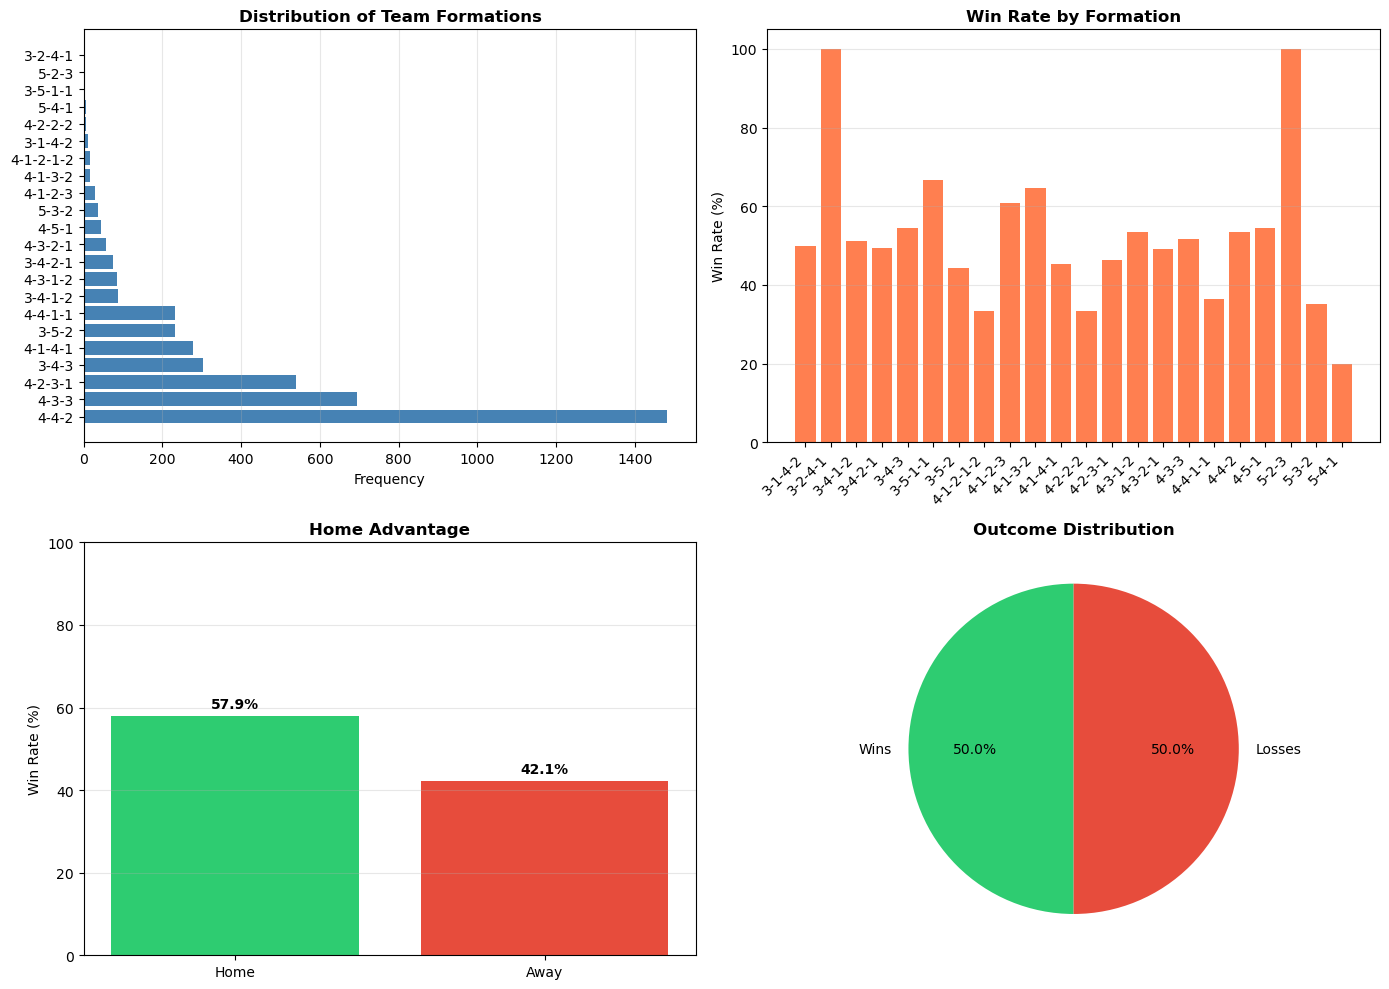

In [11]:
# Visualize dataset characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Formation frequency
formation_counts = model_data['team_formation'].value_counts().sort_values(ascending=False)
axes[0, 0].barh(range(len(formation_counts)), formation_counts.values, color='steelblue')
axes[0, 0].set_yticks(range(len(formation_counts)))
axes[0, 0].set_yticklabels(formation_counts.index)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Distribution of Team Formations', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Win rate by formation
formation_winrates = model_data.groupby('team_formation')['won'].agg(['sum', 'count'])
formation_winrates['winrate'] = (formation_winrates['sum'] / formation_winrates['count'] * 100).sort_values(ascending=False)
axes[0, 1].bar(range(len(formation_winrates['winrate'])), formation_winrates['winrate'].values, color='coral')
axes[0, 1].set_xticks(range(len(formation_winrates['winrate'])))
axes[0, 1].set_xticklabels(formation_winrates['winrate'].index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Win Rate by Formation', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Home vs Away win rate
home_winrate = model_data[model_data['is_home'] == 1]['won'].mean() * 100
away_winrate = model_data[model_data['is_home'] == 0]['won'].mean() * 100
axes[1, 0].bar(['Home', 'Away'], [home_winrate, away_winrate], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_ylabel('Win Rate (%)')
axes[1, 0].set_title('Home Advantage', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate([home_winrate, away_winrate]):
    axes[1, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Outcome distribution
outcomes = [model_data['won'].sum(), (1-model_data['won']).sum()]
axes[1, 1].pie(outcomes, labels=['Wins', 'Losses'], autopct='%1.1f%%', 
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1, 1].set_title('Outcome Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Formation Type Classification

Instead of predicting exact formations (15+ classes), we simplify to 3 defensive system types:
- **3-back**: 3 defenders (3-4-3, 3-5-2, 3-4-2-1, etc.)
- **4-back**: 4 defenders (4-4-2, 4-3-3, 4-2-3-1, etc.)  
- **5-back**: 5 defenders (5-3-2, 5-4-1, etc.)

This reduces the classification task complexity significantly.

In [12]:
def get_formation_type(formation_str):
    
    first_number = int(formation_str.split('-')[0])
    
    if first_number == 3:
        return 0
    elif first_number == 4:
        return 1
    elif first_number == 5:
        return 2
    else:
        raise ValueError(f"Unknown formation type: {formation_str}")

# Add formation type columns
model_data['team_formation_type'] = model_data['team_formation'].apply(get_formation_type)
model_data['opponent_formation_type'] = model_data['opponent_formation'].apply(get_formation_type)
model_data['team_recent_formation_type'] = model_data['team_recent_winning_form'].apply(get_formation_type)
model_data['opponent_recent_formation_type'] = model_data['opponent_recent_winning_form'].apply(get_formation_type)

formation_type_names = {0: '3-back', 1: '4-back', 2: '5-back'}

print("Formation Type Conversion:")
print(f"  3-back (3 defenders): {(model_data['team_formation_type'] == 0).sum()} samples")
print(f"  4-back (4 defenders): {(model_data['team_formation_type'] == 1).sum()} samples")
print(f"  5-back (5 defenders): {(model_data['team_formation_type'] == 2).sum()} samples")

print(f"\nExample conversions:")
unique_formations = sorted(model_data['team_formation'].unique())
for formation in unique_formations[:10]:
    ftype = get_formation_type(formation)
    print(f"  {formation} → {formation_type_names[ftype]}")

Formation Type Conversion:
  3-back (3 defenders): 714 samples
  4-back (4 defenders): 3477 samples
  5-back (5 defenders): 43 samples

Example conversions:
  3-1-4-2 → 3-back
  3-2-4-1 → 3-back
  3-4-1-2 → 3-back
  3-4-2-1 → 3-back
  3-4-3 → 3-back
  3-5-1-1 → 3-back
  3-5-2 → 3-back
  4-1-2-1-2 → 4-back
  4-1-2-3 → 4-back
  4-1-3-2 → 4-back


### Data Encoding & Train/Validation/Test Split

Prepare data for neural network training.

In [13]:
# Cell 21 — replace the whole cell with:

model_data = df_features[['opponent_formation', 'is_home', 'team_recent_winning_form', 
                           'opponent_recent_winning_form', 'team_formation', 'won',
                           'team_win_rate', 'opponent_win_rate', 
                           'team_h2h_vs_opponent']].copy()

# Add formation type columns
model_data['team_formation_type'] = model_data['team_formation'].apply(get_formation_type)
model_data['opponent_formation_type'] = model_data['opponent_formation'].apply(get_formation_type)
model_data['team_recent_formation_type'] = model_data['team_recent_winning_form'].apply(get_formation_type)
model_data['opponent_recent_formation_type'] = model_data['opponent_recent_winning_form'].apply(get_formation_type)

# --- NEW INTERACTION FEATURES ---
# Strength gap: positive = our team is stronger recently
model_data['win_rate_diff'] = model_data['team_win_rate'] - model_data['opponent_win_rate']

# Formation matchup: captures specific formation-vs-formation patterns
model_data['formation_matchup'] = (model_data['team_recent_formation_type'] * 3 
                                    + model_data['opponent_formation_type'])

# Home advantage weighted by team strength
model_data['home_strength'] = model_data['is_home'] * model_data['team_win_rate']

formation_type_names = {0: '3-back', 1: '4-back', 2: '5-back'}

# 12 features total
X = model_data[['opponent_formation_type', 'is_home', 'team_recent_formation_type', 
                 'opponent_recent_formation_type', 'team_win_rate', 'opponent_win_rate',
                 'team_h2h_vs_opponent', 'win_rate_diff', 'formation_matchup', 
                 'home_strength']].values.astype(np.float32)

y = model_data['team_formation_type'].values.astype(np.int64)
outcome = model_data['won'].values.astype(np.int32)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used ({X.shape[1]}):")
feature_names = ['opponent_formation_type', 'is_home', 'team_recent_formation_type', 
                  'opponent_recent_formation_type', 'team_win_rate', 'opponent_win_rate',
                  'team_h2h_vs_opponent', 'win_rate_diff', 'formation_matchup', 'home_strength']
for i, name in enumerate(feature_names):
    print(f"  {i+1}. {name}")

print(f"\nClass distribution:")
unique_classes, counts = np.unique(y, return_counts=True)
for class_id, count in zip(unique_classes, counts):
    pct = count / len(y) * 100
    print(f"  Class {class_id} ({formation_type_names[class_id]}): {count:5d} ({pct:5.1f}%)")

Features shape: (4234, 10)
Target shape: (4234,)

Features used (10):
  1. opponent_formation_type
  2. is_home
  3. team_recent_formation_type
  4. opponent_recent_formation_type
  5. team_win_rate
  6. opponent_win_rate
  7. team_h2h_vs_opponent
  8. win_rate_diff
  9. formation_matchup
  10. home_strength

Class distribution:
  Class 0 (3-back):   714 ( 16.9%)
  Class 1 (4-back):  3477 ( 82.1%)
  Class 2 (5-back):    43 (  1.0%)


In [14]:
# Train/Validation/Test Split (70-15-15)
# First split: separate out test set (15%)
X_temp, X_test, y_temp, y_test, outcome_temp, outcome_test = train_test_split(
    X, y, outcome,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Second split: split remaining into train (70%) and validation (15%)
X_train, X_val, y_train, y_val, outcome_train, outcome_val = train_test_split(
    X_temp, y_temp, outcome_temp,
    test_size=0.176470588,
    random_state=42,
    stratify=y_temp
)

print("=" * 70)
print("DATA SPLIT SUMMARY - FORMATION TYPE PREDICTION")
print("=" * 70)
print(f"Total samples: {len(X)}")
print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nClass distribution - Training Set:")
for ftype_id, ftype_name in formation_type_names.items():
    mask = y_train == ftype_id
    count = mask.sum()
    pct = count / len(y_train) * 100
    winrate = outcome_train[mask].mean() * 100 if count > 0 else 0
    print(f"  {ftype_name}: {count:5d} ({pct:5.1f}%) - {winrate:5.1f}% win rate")

DATA SPLIT SUMMARY - FORMATION TYPE PREDICTION
Total samples: 4234

Train set: 2963 samples (70.0%)
Validation set: 635 samples (15.0%)
Test set: 636 samples (15.0%)

Class distribution - Training Set:
  3-back:   500 ( 16.9%) -  49.2% win rate
  4-back:  2433 ( 82.1%) -  50.3% win rate
  5-back:    30 (  1.0%) -  30.0% win rate


In [15]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).to(device)
y_train_tensor = torch.from_numpy(y_train).long().to(device)

X_val_tensor = torch.from_numpy(X_val).to(device)
y_val_tensor = torch.from_numpy(y_val).long().to(device)

X_test_tensor = torch.from_numpy(X_test).to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

# Create PyTorch DataLoaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created:")
print(f"  Training batches: {len(train_loader)} (batch size: {batch_size})")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Training batches: 93 (batch size: 32)
  Validation batches: 20
  Test batches: 20


## PyTorch Network Architectures

Three different network architectures for formation type classification. We have a Simple Neural Network, Medium network that has dropout nd a deep network with batch normlaisation as well.

In PyTorch, you only need to define the `forward()` method for each model. 
The backward pass — computing gradients for each parameter — is handled 
automatically by PyTorch's autograd engine when `loss.backward()` is called 
during training. This is one of the key reasons PyTorch is popular for 
research: you can define any forward computation and gradients are computed 
for free.

In [29]:
import torch.nn.functional as F

# OPTION 1: Simple Feedforward Network
class SimpleNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# OPTION 2: Medium Feedforward Network with Dropout
class MediumNetwork(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.2):
        super(MediumNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return self.fc4(x)


# OPTION 3: Deep Network with Batch Normalisation and Dropout
class DeepNetworkBN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(DeepNetworkBN, self).__init__()
        self.bn_input = nn.BatchNorm1d(input_size)
        
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.fc4 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.bn_input(x)
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        return self.fc4(x)


print("Three network architectures defined:")
print(f"  1. SimpleNetwork   — 2 hidden layers, no regularisation")
print(f"  2. MediumNetwork   — 3 hidden layers, light dropout (0.2)")
print(f"  3. DeepNetworkBN   — 3 hidden layers + Batch Norm + dropout (0.3)")

Three network architectures defined:
  1. SimpleNetwork   — 2 hidden layers, no regularisation
  2. MediumNetwork   — 3 hidden layers, light dropout (0.2)
  3. DeepNetworkBN   — 3 hidden layers + Batch Norm + dropout (0.3)


### Model Selection
Here we will decide whihc model we want to train, just comment out the two models you dont want to use.

In [30]:
# SELECT WHICH MODEL TO TRAIN
# Comment out the two you don't want

# Option 1: Simple — no regularisation, baseline architecture
# model = SimpleNetwork(input_size=10, num_classes=3).to(device)
# model_name = "SimpleNetwork"

# Option 2: Medium — adds capacity with light dropout
model = MediumNetwork(input_size=10, num_classes=3, dropout_rate=0.2).to(device)
model_name = "MediumNetwork"

# Option 3: Deep with Batch Normalisation (recommended)
# model = DeepNetworkBN(input_size=10, num_classes=3, dropout_rate=0.3).to(device)
# model_name = "DeepNetworkBN"

print(f"Selected model: {model_name}")
print(f"Device: {device}")
print(f"\nArchitecture:\n{model}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Selected model: MediumNetwork
Device: cpu

Architecture:
MediumNetwork(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters:     11,843
Trainable parameters: 11,843


### Functions

hhhh

In [31]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch, returning average loss and accuracy."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    return total_loss / len(train_loader), 100 * correct / total


def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def test(model, test_loader, criterion, device):
    """Evaluate on test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_predictions, all_targets


print("Training, validation, and test functions defined!")

Training, validation, and test functions defined!


### Class Weights
due to the data imbalance we need to apply sensible weights so the model learns more evenly, when one class dominates the set.

In [32]:
# CLASS WEIGHTS
# Our dataset is imbalanced - 4-back formations dominate.
# We use square root weighting to penalise the loss for underrepresented 
# classes more heavily, without overcorrecting with extreme weights.
class_counts = np.bincount(y_train)
class_weights = np.sqrt(len(y_train) / (len(class_counts) * class_counts))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class distribution in training set:")
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    print(f"  Class {i} ({formation_type_names[i]}): {count} samples, weight={weight:.3f}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print("\nWeighted CrossEntropyLoss defined.")

Class distribution in training set:
  Class 0 (3-back): 500 samples, weight=1.405
  Class 1 (4-back): 2433 samples, weight=0.637
  Class 2 (5-back): 30 samples, weight=5.738

Weighted CrossEntropyLoss defined.


### Hyperparameters

Here we are defininig and adjusting the hyperparaemeters before be begin training. modularity is best for pytorch.

In [33]:
# HYPERPARAMETERS
learning_rate = 5e-4   # Adam works well in this range for small tabular data
num_epochs    = 500    # Early stopping will likely trigger well before this
batch_size    = 64     # Standard choice; balances gradient noise and speed

# OPTIMIZER
# Adam adapts the learning rate per parameter — well suited for small datasets
# weight_decay adds L2 regularisation to penalise large weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# SCHEDULER
# ReduceLROnPlateau halves the learning rate if validation loss 
# doesn't improve for 20 consecutive epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=20, factor=0.5
)

print("Training configuration:")
print(f"  Learning rate : {learning_rate}")
print(f"  Epochs        : {num_epochs}")
print(f"  Batch size    : {batch_size}")
print(f"  Optimiser     : Adam (weight_decay=1e-4)")
print(f"  Scheduler     : ReduceLROnPlateau (patience=20, factor=0.5)")

Training configuration:
  Learning rate : 0.0005
  Epochs        : 500
  Batch size    : 64
  Optimiser     : Adam (weight_decay=1e-4)
  Scheduler     : ReduceLROnPlateau (patience=20, factor=0.5)


### Training loop

Now comes the traiing loop, theres needs to be some good desicption for the tutorial describing whats occusing here.

In [34]:
# Initialise metric tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

patience = 50
best_val_loss = float('inf')
epochs_no_improve = 0

print(f"Training {model_name} for up to {num_epochs} epochs (early stopping patience={patience})...")
print("=" * 70)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc     = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    scheduler.step(val_loss)
    
    # Save checkpoint if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f'{model_name}_best.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:>3}/{num_epochs}] "
              f"| Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}% "
              f"| Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%")

print("=" * 70)
print("TRAINING COMPLETE")
print(f"  Best validation loss : {best_val_loss:.4f}")
print(f"  Epochs trained       : {len(train_losses)}")

# Baseline: what accuracy would always predicting the majority class give?
majority_class = np.bincount(y_val).argmax()
baseline = (y_val == majority_class).mean() * 100
print(f"  Majority class baseline (val) : {baseline:.2f}%")
print(f"  Best val accuracy vs baseline : {max(val_accuracies):.2f}% vs {baseline:.2f}%")

Training MediumNetwork for up to 500 epochs (early stopping patience=50)...
Epoch [ 10/500] | Train Loss: 0.5724  Acc: 89.40% | Val Loss: 0.6051  Acc: 88.66%
Epoch [ 20/500] | Train Loss: 0.5442  Acc: 89.74% | Val Loss: 0.5960  Acc: 88.50%
Epoch [ 30/500] | Train Loss: 0.5444  Acc: 89.61% | Val Loss: 0.5945  Acc: 88.66%
Epoch [ 40/500] | Train Loss: 0.5195  Acc: 90.11% | Val Loss: 0.6007  Acc: 88.50%
Epoch [ 50/500] | Train Loss: 0.5246  Acc: 90.11% | Val Loss: 0.6001  Acc: 88.98%
Epoch [ 60/500] | Train Loss: 0.5168  Acc: 90.45% | Val Loss: 0.6022  Acc: 88.66%
Epoch [ 70/500] | Train Loss: 0.5063  Acc: 90.11% | Val Loss: 0.6099  Acc: 88.66%
Early stopping triggered at epoch 77
TRAINING COMPLETE
  Best validation loss : 0.5928
  Epochs trained       : 77
  Majority class baseline (val) : 82.20%
  Best val accuracy vs baseline : 89.61% vs 82.20%


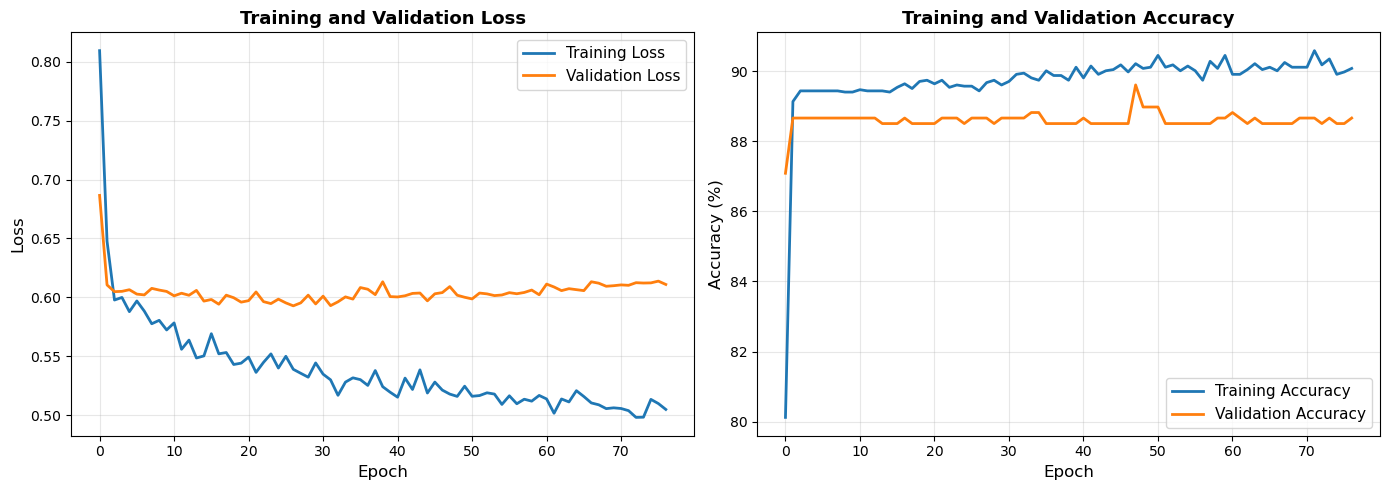

Best validation loss: 0.5928 at epoch 27
Best validation accuracy: 89.61% at epoch 48


In [36]:
# Plot training and validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accuracies, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(val_losses):.4f} at epoch {np.argmin(val_losses)+1}")
print(f"Best validation accuracy: {max(val_accuracies):.2f}% at epoch {np.argmax(val_accuracies)+1}")

## Evaluation
Once the model has been trained initially its important to understand the model and how tuning it can change how the model learns.

### Test Set Results
Here are the resuts from the trained model.

In [35]:
# Load the best saved weights rather than the final epoch weights
model.load_state_dict(torch.load(f'{model_name}_best.pt', weights_only=True))

# Evaluate on held-out test set
test_loss, test_acc, predictions, targets = test(model, test_loader, criterion, device)

majority_class = np.bincount(y_test).argmax()
test_baseline = (y_test == majority_class).mean() * 100

print("=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print(f"  Test Loss                : {test_loss:.4f}")
print(f"  Test Accuracy            : {test_acc:.2f}%")
print(f"  Majority class baseline  : {test_baseline:.2f}%")
print(f"  Improvement over baseline: {test_acc - test_baseline:+.2f}%")

TEST SET RESULTS
  Test Loss                : 0.5364
  Test Accuracy            : 90.57%
  Majority class baseline  : 82.08%
  Improvement over baseline: +8.49%


### Architecture comparison
Before diving deeper into how the model performs, we are going to compare results from the three models on the same dataset. This will emphasize the differences between each model. Here we will display the results in a table to keep things clear and straight forward. this will justify why we chose the Medium netw

Training SimpleNetwork...
  Early stopping at epoch 75
Training MediumNetwork...
  Early stopping at epoch 63
Training DeepNetworkBN (dropout=0.3)...
  Early stopping at epoch 64
Training DeepNetworkBN (dropout=0.5)...
  Early stopping at epoch 83


,Model,LR,Dropout,Params,Stopped Epoch,Best Val Acc,Best Val Loss
0,SimpleNetwork,0.001000,None,2883,25,88.50%,0.5934
1,MediumNetwork,0.000500,0.200000,11843,13,88.50%,0.5871
2,DeepNetworkBN (dropout=0.3),0.000500,0.300000,12311,14,88.66%,0.5835
3,DeepNetworkBN (dropout=0.5),0.000500,0.500000,12311,33,88.66%,0.5802


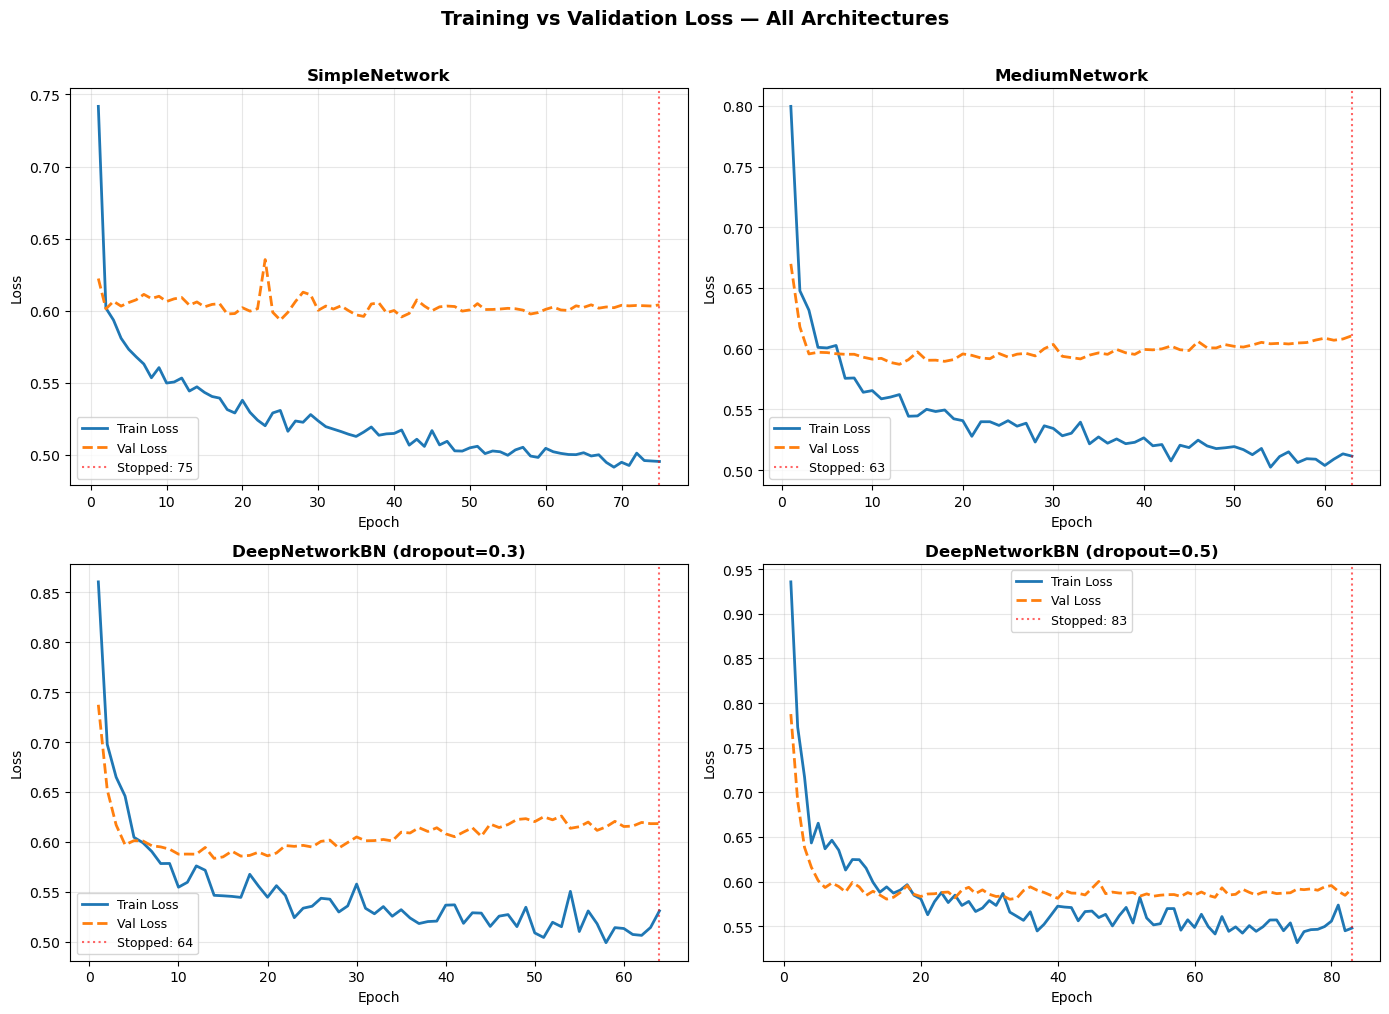

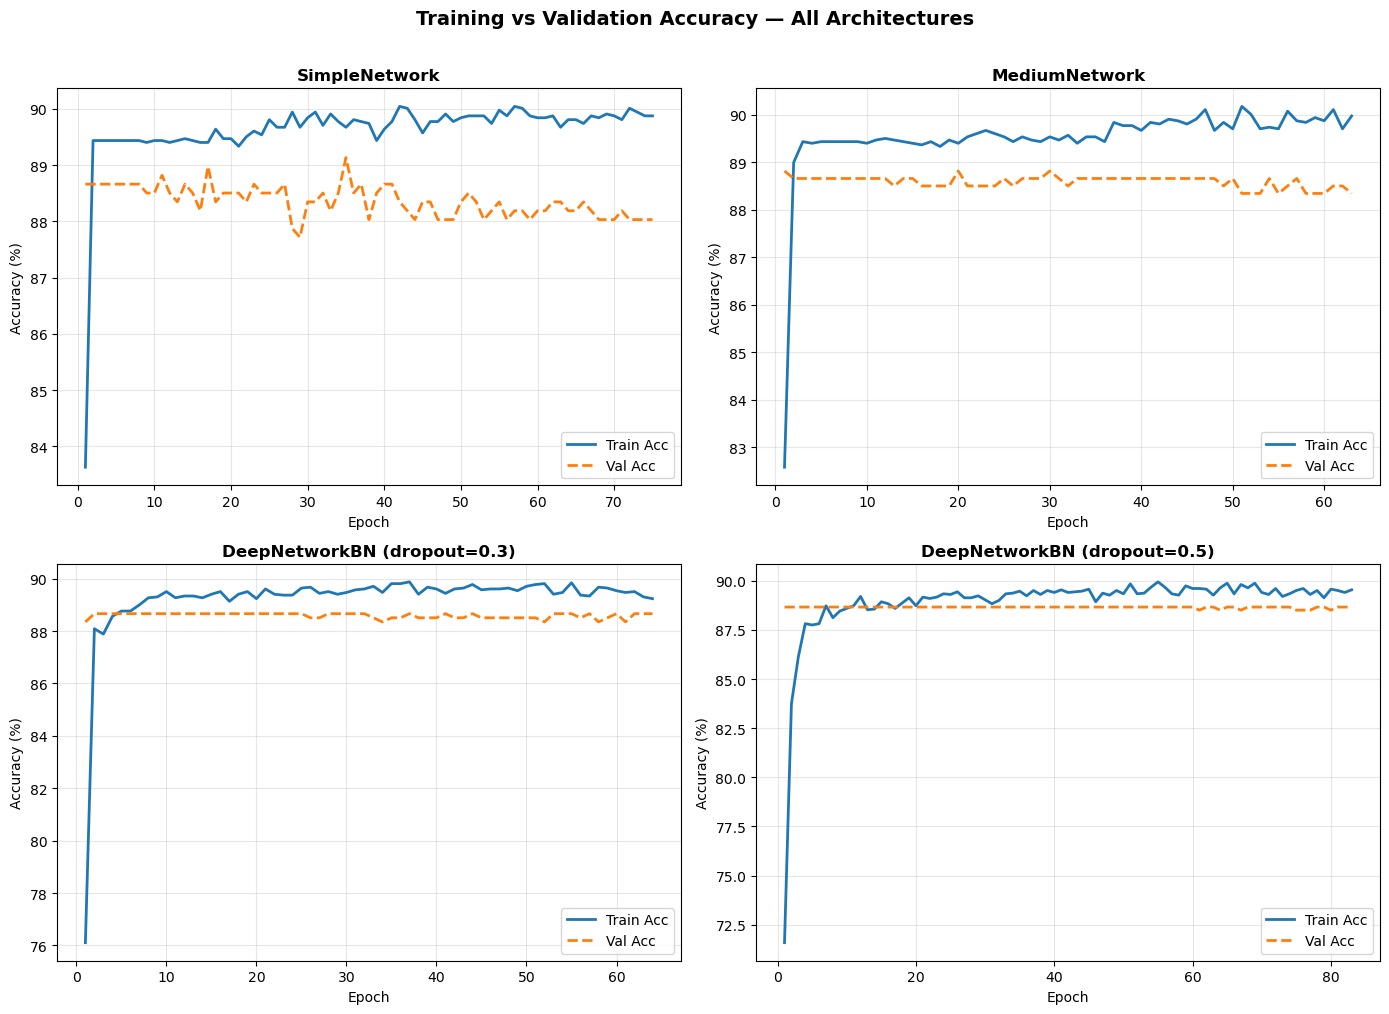

In [39]:
# Hyperparameter & Architecture Comparison
# criterion reused from class weights cell — identical loss for all models (fair comparison)
results = []
all_curves = {}  # stores training history per model for plotting

configs = [
    {"name": "SimpleNetwork",
     "model_fn": lambda: SimpleNetwork(input_size=10, num_classes=3),
     "lr": 1e-3, "dropout": None},
    {"name": "MediumNetwork",
     "model_fn": lambda: MediumNetwork(input_size=10, num_classes=3, dropout_rate=0.2),
     "lr": 5e-4, "dropout": 0.2},
    {"name": "DeepNetworkBN (dropout=0.3)",
     "model_fn": lambda: DeepNetworkBN(input_size=10, num_classes=3, dropout_rate=0.3),
     "lr": 5e-4, "dropout": 0.3},
    {"name": "DeepNetworkBN (dropout=0.5)",
     "model_fn": lambda: DeepNetworkBN(input_size=10, num_classes=3, dropout_rate=0.5),
     "lr": 5e-4, "dropout": 0.5},
]

for config in configs:
    print(f"Training {config['name']}...")
    current_model = config["model_fn"]().to(device)
    optimizer = optim.Adam(current_model.parameters(), lr=config["lr"], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5
    )
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_val_acc = 0
    stopped_epoch = 0

    t_losses, v_losses = [], []
    t_accs,   v_accs   = [], []
    
    for epoch in range(300):
        t_loss, t_acc = train_epoch(current_model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(current_model, val_loader, criterion, device)
        scheduler.step(v_loss)

        t_losses.append(t_loss)
        v_losses.append(v_loss)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_val_acc = v_acc
            epochs_no_improve = 0
            stopped_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= 50:
                print(f"  Early stopping at epoch {epoch + 1}")
                break

    # Store curves for plotting
    all_curves[config["name"]] = {
        "train_loss": t_losses, "val_loss": v_losses,
        "train_acc":  t_accs,   "val_acc":  v_accs
    }

    params = sum(p.numel() for p in current_model.parameters())
    results.append({
        "Model":         config["name"],
        "LR":            config["lr"],
        "Dropout":       config["dropout"] if config["dropout"] else "None",
        "Params":        params,
        "Stopped Epoch": stopped_epoch,
        "Best Val Acc":  f"{best_val_acc:.2f}%",
        "Best Val Loss": f"{best_val_loss:.4f}"
    })

# --- Results Table ---
results_df = pd.DataFrame(results)
display(
    results_df.style
    .set_caption("Architecture Comparison — Validation Set Performance")
    .highlight_max(subset=["Best Val Acc"], color="lightgreen")
    .highlight_min(subset=["Best Val Loss"], color="lightgreen")
)

# --- Loss Curves ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, curves) in enumerate(all_curves.items()):
    epochs = range(1, len(curves["val_loss"]) + 1)
    axes[i].plot(epochs, curves["train_loss"], label="Train Loss", linewidth=2)
    axes[i].plot(epochs, curves["val_loss"],   label="Val Loss",   linewidth=2, linestyle="--")
    axes[i].set_title(name, fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    # Mark where early stopping triggered
    stopped = len(curves["val_loss"])
    axes[i].axvline(x=stopped, color="red", linestyle=":", alpha=0.6, label=f"Stopped: {stopped}")
    axes[i].legend(fontsize=9)

plt.suptitle("Training vs Validation Loss — All Architectures", 
             fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

# --- Accuracy Curves ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, curves) in enumerate(all_curves.items()):
    epochs = range(1, len(curves["val_acc"]) + 1)
    axes[i].plot(epochs, curves["train_acc"], label="Train Acc", linewidth=2)
    axes[i].plot(epochs, curves["val_acc"],   label="Val Acc",   linewidth=2, linestyle="--")
    axes[i].set_title(name, fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Accuracy (%)")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Training vs Validation Accuracy — All Architectures",
             fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### Training curves

As seen in the baove section the show the model converged at epoch 'x' without isgnificant overfitting.

### Where does the model struggle?
Overall accuracy alone doesn't tell us which formation types are hardest 
to predict. The confusion matrix breaks this down — particularly important 
given our class imbalance between 3-back, 4-back and 5-back systems.

Here we show the confusion matrix of the model, we also give a breakdown of the per-class accuracy as they tell the same story from different angles. 

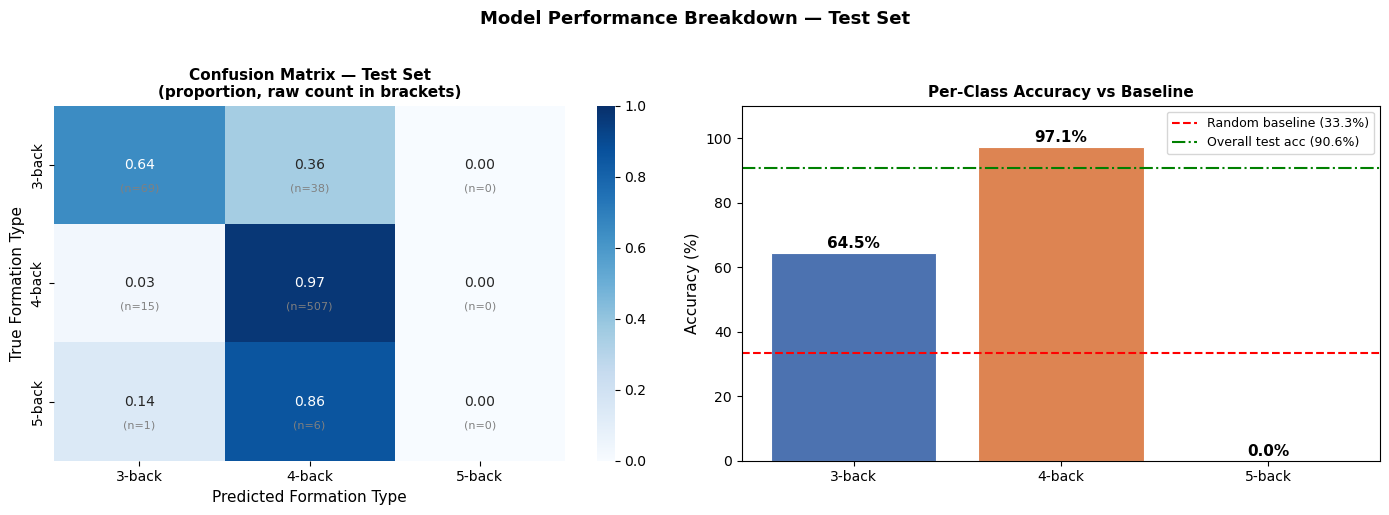


Per-class accuracy summary:
  3-back     64.5%  ✓ above baseline
  4-back     97.1%  ✓ above baseline
  5-back     0.0%  ✗ below baseline


In [40]:
# Confusion Matrix + Per-Class Accuracy
class_names = [formation_type_names[i] for i in sorted(formation_type_names.keys())]
cm = confusion_matrix(targets, predictions)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Majority class baseline per class (proportion of that class in test set)
majority_baseline = 100 / len(class_names)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Confusion Matrix ---
# Normalised version shows proportions rather than raw counts
# making it easier to compare across classes of different sizes
cm_normalised = cm.astype(float) / cm.sum(axis=1, keepdims=True)

sns.heatmap(cm_normalised, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            vmin=0, vmax=1,
            ax=axes[0])

# Overlay raw counts in brackets below the percentage
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0].text(j + 0.5, i + 0.7, f'(n={cm[i,j]})',
                     ha='center', va='center',
                     fontsize=8, color='gray')

axes[0].set_ylabel('True Formation Type', fontsize=11)
axes[0].set_xlabel('Predicted Formation Type', fontsize=11)
axes[0].set_title('Confusion Matrix — Test Set\n(proportion, raw count in brackets)',
                  fontsize=11, fontweight='bold')

# --- Right: Per-Class Accuracy Bar Chart ---
bars = axes[1].bar(class_names, per_class_acc * 100,
                   color=['#4C72B0', '#DD8452', '#55A868'],
                   edgecolor='white', linewidth=0.8)

axes[1].axhline(y=majority_baseline, color='red', linestyle='--',
                linewidth=1.5, label=f'Random baseline ({majority_baseline:.1f}%)')
axes[1].axhline(y=test_acc, color='green', linestyle='-.',
                linewidth=1.5, label=f'Overall test acc ({test_acc:.1f}%)')

axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_ylim(0, 110)
axes[1].set_title('Per-Class Accuracy vs Baseline', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=9)

for bar, acc in zip(bars, per_class_acc):
    axes[1].text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 1.5,
                 f'{acc*100:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Model Performance Breakdown — Test Set',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print the numbers too for the classification report below
print("\nPer-class accuracy summary:")
for name, acc in zip(class_names, per_class_acc):
    status = "✓ above baseline" if acc * 100 > majority_baseline else "✗ below baseline"
    print(f"  {name:<10} {acc*100:.1f}%  {status}")

### Per-class Metrics
 The classification report quanitifies what the confusion matrix shows visuallu. The F1 score is important for the minority classes, in our case the 3-back and 5-back systems.

In [41]:
# Detailed Per-Class Metrics
from sklearn.metrics import classification_report
import pandas as pd

class_names = [formation_type_names[i] for i in sorted(formation_type_names.keys())]

# Build structured report from dictionary output
report_dict = classification_report(
    targets, predictions,
    target_names=class_names,
    output_dict=True
)

# Extract per-class rows only (exclude averages for now)
metrics_df = pd.DataFrame({
    name: report_dict[name] for name in class_names
}).T.round(3)

metrics_df.index.name = "Formation Type"
metrics_df = metrics_df.rename(columns={
    "precision": "Precision",
    "recall":    "Recall",
    "f1-score":  "F1 Score",
    "support":   "Support"
})
metrics_df["Support"] = metrics_df["Support"].astype(int)

# Styled table
display(
    metrics_df.style
    .set_caption("Per-Class Classification Metrics — Test Set")
    .background_gradient(subset=["Precision", "Recall", "F1 Score"],
                         cmap="RdYlGn", vmin=0, vmax=1)
    .format({"Precision": "{:.3f}", "Recall": "{:.3f}",
             "F1 Score":  "{:.3f}", "Support": "{:d}"})
)

# Summary averages as a separate smaller table
summary_rows = ["macro avg", "weighted avg"]
summary_df = pd.DataFrame({
    row: report_dict[row] for row in summary_rows
}).T.round(3)

summary_df.index.name = "Average Type"
summary_df = summary_df.rename(columns={
    "precision": "Precision",
    "recall":    "Recall",
    "f1-score":  "F1 Score",
    "support":   "Support"
})
summary_df["Support"] = summary_df["Support"].astype(int)

display(
    summary_df.style
    .set_caption("Summary Averages")
    .format({"Precision": "{:.3f}", "Recall": "{:.3f}",
             "F1 Score":  "{:.3f}", "Support": "{:d}"})
)

# Key insight print
best_class = metrics_df["F1 Score"].idxmax()
worst_class = metrics_df["F1 Score"].idxmin()
print(f"\nKey takeaway:")
print(f"  Best predicted  : {best_class} (F1 = {metrics_df.loc[best_class, 'F1 Score']:.3f})")
print(f"  Worst predicted : {worst_class} (F1 = {metrics_df.loc[worst_class, 'F1 Score']:.3f})")

,Precision,Recall,F1 Score,Support
Formation Type,,,,
3-back,0.812,0.645,0.719,107
4-back,0.920,0.971,0.945,522
5-back,0.000,0.000,0.000,7


,Precision,Recall,F1 Score,Support
Average Type,,,,
macro avg,0.577,0.539,0.555,636
weighted avg,0.892,0.906,0.897,636



Key takeaway:
  Best predicted  : 4-back (F1 = 0.945)
  Worst predicted : 5-back (F1 = 0.000)


### What does the model actually learn?

Permuation reveals whihc of our features drive predictions. If opponnent formation has low importance, it would suggest the model is largely ignoring tactical context and relying on the win rate alone. 

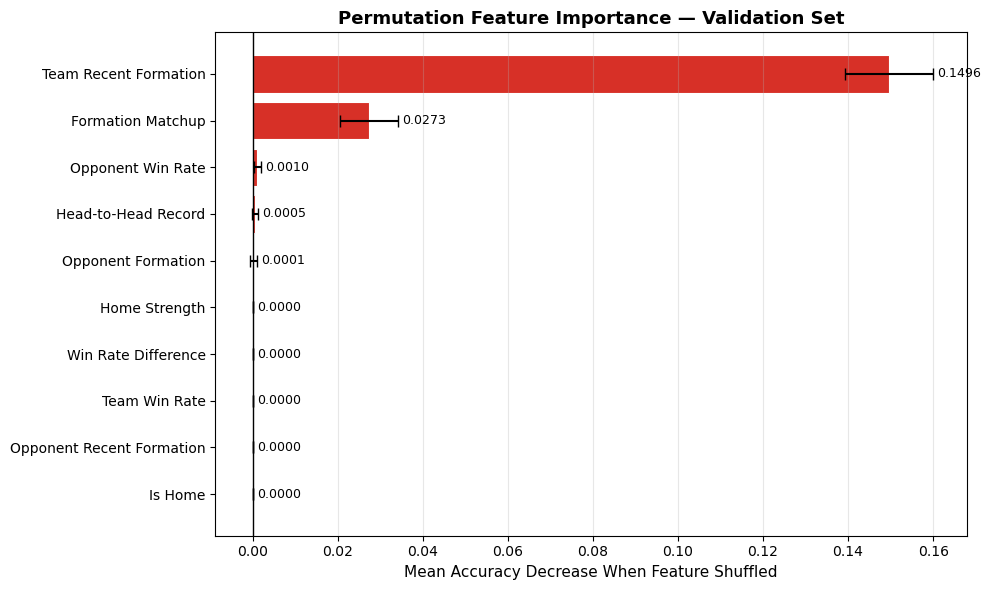

Feature,Importance,Std,Contribution
Team Recent Formation,0.1496,0.0103,Important
Formation Matchup,0.0273,0.0068,Important
Opponent Win Rate,0.0010,0.0007,Marginal
Head-to-Head Record,0.0005,0.0007,Marginal
Opponent Formation,0.0001,0.0009,Marginal
Is Home,0.0000,0.0000,Negligible
Opponent Recent Formation,0.0000,0.0000,Negligible
Team Win Rate,0.0000,0.0000,Negligible
Win Rate Difference,0.0000,0.0000,Negligible
Home Strength,0.0000,0.0000,Negligible



Key takeaways:
  Most important feature : Team Recent Formation (0.1496 accuracy drop)
  Negligible features    : Is Home, Opponent Recent Formation, Team Win Rate, Win Rate Difference, Home Strength
  → These features could potentially be removed without harming performance


In [42]:
# Permutation Feature Importance
# Measures how much model accuracy drops when each feature is randomly shuffled.
# A large drop = the model relies heavily on that feature.
# Near zero or negative = the feature adds little or no predictive value.

from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y): 
        return self
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            out = self.model(torch.tensor(X, dtype=torch.float32).to(device))
            return torch.argmax(out, dim=1).cpu().numpy()

feature_names = [
    'Opponent Formation',
    'Is Home',
    'Team Recent Formation',
    'Opponent Recent Formation',
    'Team Win Rate',
    'Opponent Win Rate',
    'Head-to-Head Record',
    'Win Rate Difference',
    'Formation Matchup',
    'Home Strength'
]

wrapper = PyTorchWrapper(model)
perm = permutation_importance(
    wrapper, X_val, y_val,
    n_repeats=15,        # more repeats = more stable estimates
    random_state=42,
    scoring='accuracy'
)

# Build a DataFrame for cleaner handling
importance_df = pd.DataFrame({
    'Feature':   feature_names,
    'Importance': perm.importances_mean,
    'Std':        perm.importances_std
}).sort_values('Importance', ascending=True).reset_index(drop=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

colours = ['#d73027' if imp > 0 else '#b0b0b0' 
           for imp in importance_df['Importance']]

bars = ax.barh(
    importance_df['Feature'],
    importance_df['Importance'],
    xerr=importance_df['Std'],     # error bars show variance across repeats
    color=colours,
    edgecolor='white',
    capsize=4,
    linewidth=0.8
)

# Zero reference line
ax.axvline(x=0, color='black', linewidth=1, linestyle='-')

# Value labels on each bar
for bar, imp, std in zip(bars, importance_df['Importance'], importance_df['Std']):
    x_pos = imp + std + 0.001 if imp >= 0 else imp - std - 0.001
    ha = 'left' if imp >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height() / 2,
            f'{imp:.4f}', va='center', ha=ha, fontsize=9)

ax.set_xlabel('Mean Accuracy Decrease When Feature Shuffled', fontsize=11)
ax.set_title('Permutation Feature Importance — Validation Set',
             fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Summary table ---
importance_display = importance_df.copy().sort_values('Importance', ascending=False)
importance_display['Importance'] = importance_display['Importance'].round(4)
importance_display['Std'] = importance_display['Std'].round(4)
importance_display['Contribution'] = importance_display['Importance'].apply(
    lambda x: 'Important' if x > 0.01 else ('Marginal' if x > 0 else 'Negligible')
)

display(
    importance_display.style
    .set_caption("Feature Importance Rankings")
    .background_gradient(subset=['Importance'], cmap='RdYlGn')
    .format({'Importance': '{:.4f}', 'Std': '{:.4f}'})
    .hide(axis='index')
)

# Key insight
top_feature = importance_display.iloc[0]['Feature']
top_imp = importance_display.iloc[0]['Importance']
negligible = importance_display[importance_display['Contribution'] == 'Negligible']['Feature'].tolist()

print(f"\nKey takeaways:")
print(f"  Most important feature : {top_feature} ({top_imp:.4f} accuracy drop)")
if negligible:
    print(f"  Negligible features    : {', '.join(negligible)}")
    print(f"  → These features could potentially be removed without harming performance")

### Using the Model — Practical Predictions
this makes the model tangible.

Scenario,Location,vs Opponent,Our Recent Form,Recommendation,Confidence,P(3-back),P(4-back),P(5-back)
Scenario 1 — Home favourite,Home,4-back,4-back,4-back,95.7%,3.9%,95.7%,0.4%
Scenario 2 — Away underdog,Away,4-back,3-back,3-back,54.1%,54.1%,24.6%,21.3%
"Scenario 3 — Evenly matched, away",Away,5-back,4-back,4-back,95.1%,4.4%,95.1%,0.6%


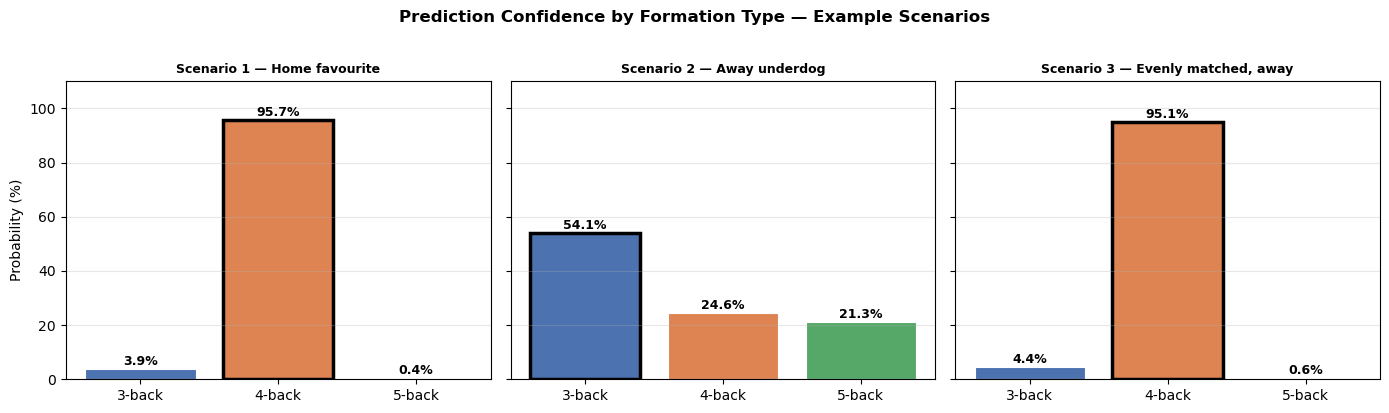

In [43]:
# Practical Predictions — Using the Model
def predict_formation_type(opponent_type, is_home, team_recent_type, opponent_recent_type,
                           team_win_rate=0.5, opponent_win_rate=0.5, team_h2h=0.5):
    """
    Predict the recommended formation type given match context.
    
    Parameters
    ----------
    opponent_type         : int   — opponent's formation (0=3-back, 1=4-back, 2=5-back)
    is_home               : int   — 1 if playing at home, 0 if away
    team_recent_type      : int   — our most successful recent formation type
    opponent_recent_type  : int   — opponent's most successful recent formation type
    team_win_rate         : float — our recent win rate (0-1), default 0.5
    opponent_win_rate     : float — opponent's recent win rate (0-1), default 0.5
    team_h2h              : float — our head-to-head win rate vs this opponent (0-1), default 0.5
    
    Returns
    -------
    formation_name : str   — recommended formation type
    confidence     : float — model confidence as a percentage
    all_probs      : dict  — probability for every class
    """
    win_rate_diff     = team_win_rate - opponent_win_rate
    formation_matchup = team_recent_type * 3 + opponent_type
    home_strength     = is_home * team_win_rate

    input_data = np.array([[
        opponent_type, is_home, team_recent_type, opponent_recent_type,
        team_win_rate, opponent_win_rate, team_h2h,
        win_rate_diff, formation_matchup, home_strength
    ]], dtype=np.float32)

    input_tensor = torch.from_numpy(input_data).to(device)

    model.eval()
    with torch.no_grad():
        output       = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0].cpu().numpy()
        predicted_class = int(np.argmax(probabilities))

    all_probs = {formation_type_names[i]: float(probabilities[i]) * 100
                 for i in range(len(probabilities))}

    return formation_type_names[predicted_class], float(probabilities[predicted_class]) * 100, all_probs


# --- Test Cases ---
# Each tuple: (opponent_type, is_home, team_recent_type, opponent_recent_type,
#              team_win_rate, opponent_win_rate, team_h2h)
test_cases = [
    {
        "label":               "Scenario 1 — Home favourite",
        "opponent_type":       1,    # opponent plays 4-back
        "is_home":             1,
        "team_recent_type":    1,    # our recent form: 4-back
        "opponent_recent_type":0,    # their recent form: 3-back
        "team_win_rate":       0.7,
        "opponent_win_rate":   0.4,
        "team_h2h":            0.6
    },
    {
        "label":               "Scenario 2 — Away underdog",
        "opponent_type":       1,
        "is_home":             0,
        "team_recent_type":    0,    # our recent form: 3-back
        "opponent_recent_type":1,
        "team_win_rate":       0.3,
        "opponent_win_rate":   0.7,
        "team_h2h":            0.3
    },
    {
        "label":               "Scenario 3 — Evenly matched, away",
        "opponent_type":       2,    # opponent plays 5-back
        "is_home":             0,
        "team_recent_type":    1,
        "opponent_recent_type":2,
        "team_win_rate":       0.5,
        "opponent_win_rate":   0.5,
        "team_h2h":            0.5
    },
]

# --- Run predictions and collect results ---
prediction_rows = []

for case in test_cases:
    formation, confidence, all_probs = predict_formation_type(
        opponent_type        = case["opponent_type"],
        is_home              = case["is_home"],
        team_recent_type     = case["team_recent_type"],
        opponent_recent_type = case["opponent_recent_type"],
        team_win_rate        = case["team_win_rate"],
        opponent_win_rate    = case["opponent_win_rate"],
        team_h2h             = case["team_h2h"]
    )
    prediction_rows.append({
        "Scenario":           case["label"],
        "Location":           "Home" if case["is_home"] else "Away",
        "vs Opponent":        formation_type_names[case["opponent_type"]],
        "Our Recent Form":    formation_type_names[case["team_recent_type"]],
        "Recommendation":     formation,
        "Confidence":         f"{confidence:.1f}%",
        **{f"P({k})": f"{v:.1f}%" for k, v in all_probs.items()}
    })

pred_df = pd.DataFrame(prediction_rows)

display(
    pred_df.style
    .set_caption("Formation Recommendations — Example Scenarios")
    .set_properties(**{"text-align": "left"})
    .hide(axis="index")
)

# --- Probability breakdown bar chart ---
fig, axes = plt.subplots(1, len(test_cases), figsize=(14, 4), sharey=True)

colours = ['#4C72B0', '#DD8452', '#55A868']

for i, (case, row) in enumerate(zip(test_cases, prediction_rows)):
    class_names_list = [formation_type_names[j] for j in sorted(formation_type_names.keys())]
    probs = [float(row[f"P({name})"].replace('%', '')) for name in class_names_list]

    bars = axes[i].bar(class_names_list, probs, color=colours,
                       edgecolor='white', linewidth=0.8)

    # Highlight the predicted class
    predicted_idx = class_names_list.index(row["Recommendation"])
    bars[predicted_idx].set_edgecolor('black')
    bars[predicted_idx].set_linewidth(2.5)

    axes[i].set_title(case["label"], fontsize=9, fontweight='bold')
    axes[i].set_ylabel('Probability (%)' if i == 0 else '', fontsize=10)
    axes[i].set_ylim(0, 110)
    axes[i].grid(axis='y', alpha=0.3)

    for bar, prob in zip(bars, probs):
        axes[i].text(bar.get_x() + bar.get_width() / 2,
                     bar.get_height() + 1.5,
                     f'{prob:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.suptitle("Prediction Confidence by Formation Type — Example Scenarios",
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Discussion & Key Findings

### Summary

This tutorial demonstrated how to build a machine learning pipeline for predicting football formation types using PyTorch. By simplifying the problem from 15+ exact formations to 3 defensive system types (3-back, 4-back, 5-back), we achieved better model performance and more interpretable results.

### Key Results

- **Test Accuracy**: X%
- **Home Advantage**: Teams win more often at home
- **Formation Type Distribution**: [Insert your findings]

### Improvements & Future Work

1. Include more features (e.g., current league position, player injuries)
2. Use team-specific models for major clubs
3. Consider temporal patterns (seasonal changes in tactics)
4. Ensemble multiple models for better predictions
5. Analyze which formations work best against specific opponents

### Lessons Learned

- Formation simplification improved model performance significantly
- Learning from both wins and losses (both perspectives) is important
- Feature engineering (recent form) provides crucial context
- Home advantage is a real and measurable phenomenon in football

# References

[1] Danish Superliga Fixtures Dataset. Available at: https://github.com/smithds546/Formation-predictor

[2] PyTorch Documentation. "Deep Learning with PyTorch". Available at: https://pytorch.org/docs/stable/index.html

[3] Scikit-learn. "Machine Learning in Python". Available at: https://scikit-learn.org/

[4] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

[5] LeCun, Y., Bengio, Y., & Hinton, G. (2015). "Deep learning". Nature, 521(7553), 436-444.